# **Atividade 03 - Visão Computacional e Percepção** 

\\

---

**Alunos:**
- Glenda Proença Train
- Jhoser Alaff dos Santos Matheus

\\

---
**Especificação:**

* Estude o paper Color Indexing do Swain & Ballard.
  * https://www.inf.ed.ac.uk/teaching/courses/av/LECTURE_NOTES/swainballard91.pdf 

* Conjunto de dados:
  * Escolha alguns objetos coloridos 
  * Alguns com cores similares mas em proporções diferentes
  * Outros com a proporção de cores similar
  * Outros com cores bem distintas entre objetos 
  
* Sugestão: 6 objetos

* Insira os objetos em cenas diversas 

* Sugestão: 12 cenas, 1 a 4 objetos por cena.

* Procure variar a situação, tendo:
  * Cenas onde claramente as cores dos objetos sejam distintas do entorno e
  * Outros casos com cores similares ao entorno.

* Experimente localizar os objetos nas cenas utilizando o algoritmo proposto por Swain & Ballard.

* Mostre resultados e discuta conclusões

* Não precisa fazer upload das imagens, basta estarem presentes em relatório sucinto.

* **Data de Entrega:** 09/05

\\

---

**Imagens dos objetos foram extraídas de:**
* https://konklab.fas.harvard.edu/#

\\

---

#### Download das Imagens

In [146]:
%%capture
!wget https://konklab.fas.harvard.edu/ImageSets/BigSmallObjects.zip
!unzip -o BigSmallObjects.zip

In [147]:
%%capture
!wget https://github.com/glenda-train/ativ_03_visao_e_percepcao/archive/refs/heads/main.zip
!unzip -o main.zip

* Importações

In [148]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

### **Identificação | Interseção de Histogramas**
**1)** Normaliza os canais R, G, e B.

**2)** Calcula as Cores Opontentes
- wb
- rg
- by

**3)** Calcula os Histogramas
- wb | 8 bins
- rg | 16 bins
- by | 16 bins

**4)** Calcula o Histograma Cumulativo

**5)** Calcula a Interseção de Histogramas

**6)** Calcula o valor de *Match* normalizado

#### **1)** Normalização e Cálculo das Cores Oponentes

In [149]:
# ----------------------------------------------------------------------------------------------------------------

# Função que transforma os canais RGB de uma imagem nas cores oponentes (pode devolver o resultado normalizado)
def rgb_to_opponent_colors(image_rgb, normalize=True):

  # Transforma a imagem de uint para float
  image_rgb_float = image_rgb.astype(np.float32)

  # Separa os canais da imagem RGB
  r, g, b = cv2.split(image_rgb_float)

  # Normaliza
  if(normalize):
    sum_ = r + g + b
    sum_ = np.where(sum_==0, 255*3, sum_)

    r = r / sum_
    g = g / sum_
    b = b / sum_

  # Calcula as cores oponentes
  rg = r - g
  by = 2 * b - r - g
  wb = r + g + b

  # Combina os canais em uma imagem novamente
  oponnent_colors_image = cv2.merge([rg, by, wb])

  return(oponnent_colors_image)
# ----------------------------------------------------------------------------------------------------------------

#### **2)** Cálculo dos Histogramas

In [150]:
# ----------------------------------------------------------------------------------------------------------------

# Função que calcula o histograma de um canal de uma imagem, considerando cada bin como um intervalo
def get_channel_histogram(channel, interval, normalized=False):

  if(not normalized):

    # Calcula o histograma da imagem (0 - 255)
    # hist = cv2.calcHist([channel], [0], None, [interval], [0, 256])
    hist, bins = np.histogram([channel], bins=interval, range=(0, 256))

  else:

    # Calcula o histograma da imagem (0 - 1)
    hist, bins = np.histogram([channel], bins=interval, range=(0, 1))

  return(hist, bins)
# ----------------------------------------------------------------------------------------------------------------

# Função que calcula o histograma para todos os canais da imagem
def get_image_histogram(image, intervals=(16, 16, 8), normalized=False):

  # Divide a imagem nos 3 canais
  channel_1, channel_2, channel_3 = cv2.split(image)

  # Calcula o histograma de cada canal
  hist_channel_1, bins_channel_1 = get_channel_histogram(channel_1, intervals[0], normalized=normalized)
  hist_channel_2, bins_channel_2 = get_channel_histogram(channel_2, intervals[1], normalized=normalized)
  hist_channel_3, bins_channel_3 = get_channel_histogram(channel_3, intervals[2], normalized=normalized)

  # Cria uma estrutura para acessar os histogramas
  hist = {
      "channel_1": hist_channel_1,
      "channel_2": hist_channel_2,
      "channel_3": hist_channel_3,
  }

  # Cria uma estrutura para acessar os bins
  bins = {
      "channel_1": bins_channel_1,
      "channel_2": bins_channel_2,
      "channel_3": bins_channel_3,
  }

  return(hist, bins)
# ----------------------------------------------------------------------------------------------------------------

# Função que acessa o histograma
def access_histogram(hist, x, y, z):
  
  value = hist["channel_1"][x] + hist["channel_2"][y] + hist["channel_3"][z]
  return(value)
# ----------------------------------------------------------------------------------------------------------------

#### **3)** Cálculo do Histograma Cumulativo

In [151]:
# ----------------------------------------------------------------------------------------------------------------

# Função que calcula o histograma cumulativo de todos os canais da imagem
def get_cumulative_histogram(hist, x, y, z):
  sum_ = 0
    
  # Faz o cálulo cumulativo
  for i in range(x):
    for j in range(y):
      for k in range(z):
        sum_ += access_histogram(hist, i, j, k)
  
  return(sum_)
# ----------------------------------------------------------------------------------------------------------------

#### **4)** Cálculo da Interseção de Histogramas

In [152]:
# ----------------------------------------------------------------------------------------------------------------

# Função que descobre o valor de interseção dos histogramas (Histogram Intersection)
def get_intersection_value(hist_1, hist_2, intervals):
  intersec_sum = 0

  # Percorre todos os bins
  for i in range(intervals[0]):
    for j in range(intervals[1]):
      for k in range(intervals[2]):

        # Acesso o valor correspondente ao índice atual em cada histograma
        hist_1_value = access_histogram(hist_1, i, j, k)
        hist_2_value = access_histogram(hist_2, i, j, k)

        # Adiciona o mínimo entre os valores a soma
        intersec_sum += min(hist_1_value, hist_2_value)

  return(intersec_sum)
# ----------------------------------------------------------------------------------------------------------------

#### **5)** Cálculo do Valor de Match Normalizado

In [153]:
# ----------------------------------------------------------------------------------------------------------------

# Função que calcula o valor de match entre dois histogramas
def get_match_value(hist_1, hist_2, intervals=(16, 16, 8)):

  # Calcula o valor de interseção dos dois histogramas
  intersec_value = get_intersection_value(hist_1, hist_2, intervals)

  # Calcula o valor total cumulativo do histograma 2 (para normalizar)
  cumulative_value = get_cumulative_histogram(hist_2, intervals[0], intervals[1], intervals[2])

  # Calcula o valor de match 
  match_value = intersec_value / (cumulative_value + 1e-7)

  return(match_value)
# ----------------------------------------------------------------------------------------------------------------

--- 


### **Localização | Backprojection de Histogramas**
**1)** Calcula a razão R entre os histogramas

**2)** Substitui os valores das imagens pelos valores de R nos índices correspondentes

**3)** Cria o kernel Dr

**4)** Convolve a imagem com o kernel Dr

**5)** Obtém as coordenadas de localização do objeto

*   Calcula a razão R entre os histogramas

In [154]:
def calc_histogram_ratio( M, I):
  # Define a estrutura para guardar as probabilidades 
  R = {
      "channel_1": np.zeros((len(M)), np.float32),
      "channel_2": np.zeros((len(M)), np.float32),
      "channel_3": np.zeros((len(M)), np.float32),
  }
  # Calcula as probabilidades
  R['channel_1'] = M['channel_1'] / (I['channel_1'] + 1e-7)
  R['channel_2'] = M['channel_2'] / (I['channel_2'] + 1e-7)
  R['channel_3'] = M['channel_3'] / (I['channel_3'] + 1e-7)

  for channel in R:
    for i in range(len(R[channel])):
      R[channel][i] = min(R[channel][i], 1.0)


  return R;

*   Substitui os valores das imagens pelos valores de R nos índices correspondentes

In [155]:
# Escolhe novo valor de pixel conforme o intervalo que ele se encontra
def choose_new_pixel(value, R, bins):
  # Intervalo 1
  if(value >= bins[0] and value < bins[1]):
    return (R[0])

  # Intervalo 2
  elif(value >= bins[1] and value < bins[2]):
    return (R[1])

  # Intervalo 3
  elif(value >= bins[2] and value < bins[3]):
    return (R[2])

  # Intervalo 4
  elif(value >= bins[3] and value < bins[4]):
    return (R[3])

  # Intervalo 5
  elif(value >= bins[4] and value < bins[5]):
    return (R[4])

  # Intervalo 6
  elif(value >= bins[5] and value < bins[6]):
    return (R[5])

  # Intervalo 7
  elif(value >= bins[6] and value < bins[7]):
    return (R[6])

  # Intervalo 8
  elif(value >= bins[7] and value < bins[8]):
    return (R[7])

  # Caso o canal tenha menos de 16 niveis
  if len(R) < 16:
    return value

  # Intervalo 9
  elif(value >= bins[8] and value < bins[9]):
    return (R[8])

  # Intervalo 10
  elif(value >= bins[9] and value < bins[10]):
    return (R[9])

  # Intervalo 11
  elif(value >= bins[10] and value < bins[11]):
    return (R[10])

  # Intervalo 12
  elif(value >= bins[11] and value < bins[12]):
    return (R[11])

  # Intervalo 13
  elif(value >= bins[12] and value < bins[13]):
    return (R[12])

  # Intervalo 14
  elif(value >= bins[13] and value < bins[14]):
    return (R[13])

  # Intervalo 15
  elif(value >= bins[14] and value < bins[15]):
    return (R[14])

  # Intervalo 16
  else:#if(value >= bins[15] and value < bins[16]):
    return (R[15])
  # else:
  #   return(value)

  return new_image

In [156]:
def Map_R_to_B(image, R, bins):
  new_image = image.copy()
  for row in range(new_image.shape[0]):
    for col in range(new_image.shape[1]):
      new_image[row, col] = choose_new_pixel(new_image[row, col], R, bins)
  return new_image

In [157]:
# Gera nova imagem B a partir dos valores de R
def generate_B_image(scene_image, R, bins):
  # Divide a imagem em canais  
  rg, by, wb = cv2.split(scene_image)

  # Mapeia nova imagem de acordo com a probabilidade de cada pixel fazer parte da imagem desejada
  nrg = Map_R_to_B(rg, R['channel_1'], bins["channel_1"])
  nby = Map_R_to_B(by, R['channel_2'], bins['channel_2'])
  nwb = Map_R_to_B(wb, R['channel_3'], bins['channel_3'])

  B = cv2.merge([nrg, nby, nwb])

  return (B)

*   Cria o kernel Dr

In [158]:
def create_disk_kernel(radius):
    # Determinar o tamanho do kernel
    size = 2 * radius + 1

    # Criar um kernel preenchido com zeros
    kernel = np.zeros((size, size))

    # Calcular as coordenadas do centro do kernel
    center = (radius, radius)

    # Preencher o kernel com valores do disco
    for i in range(size):
        for j in range(size):
            distance = np.sqrt((i - center[0])**2 + (j - center[1])**2)
            if distance <= radius:
                kernel[i, j] = 1

    # Normalizar o kernel para que a soma dos elementos seja igual a 1
    kernel /= np.sum(kernel)

    return kernel



*   Convolve a imagem com o kernel Dr




In [159]:
# Convoluciona com um kernel circular 
def kernel_convolution(image, disc):

  result = cv2.filter2D(image, -1, disc)

  return result



*   Converte a imagem de cores oponentes para RGB



In [160]:
def opponent_colors_to_rgb(opponent_colors_image):
  rg, by, wb = cv2.split(opponent_colors_image)

  # Reverte os canais para RGB
  g = (2 * wb - 3 * rg - by) / 6
  r = rg + g
  b = (by + rg + 2 * g) / 2

  RGB = cv2.merge([r, g, b])

  return (RGB)



*   Enconta o objeto na imagem cena




In [161]:
def find_object(result_image, limit=0.40):
  # Escolhe a imagem que convoluída
  to_thresh = result_image

  # Escolhe um canal da imagem e transforma no intervalo de 0-255
  ret, thresh = cv2.threshold(to_thresh, limit, np.max(to_thresh), 0)
  thresh = (thresh[:,:, 0] * 255).astype(np.uint8)

  # Calcula o contorno (os pontos que definem o objeto) do objeto encontrado pelo threshold
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Calcula as áreas dos contornos e encontra a maior área
  areas = []
  max_area = 0
  id = -1
  for index, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    areas.append(area)

    if(area > max_area):
      max_area = area
      id = index

  coords = []
  # Encontra os bounding boxes dos objetos
  for index, contour in enumerate(contours):

    # Se a área de um contorno é menos da metade do maior contorno, então ela é removida (região muito pequena)
    if(areas[index] < max_area / 2):
      continue

    x,y,w,h = cv2.boundingRect(contour)
    coords.append((x,y,w,h))

  return(coords)


*   Funções de plot

In [162]:
# Função de plot do processo de identificação e localização
def plot_images(images, titles, title="", num_rows=2, fig_size=(15 , 10)):
  
  # Definições do plot
  ## Número de colunas no plot
  num_images = len(images)
  is_divisible = num_images % num_rows
  num_cols = (num_images // num_rows) + 1 if is_divisible else num_images // num_rows

  ## Criação do plot
  subplot_config = (num_rows, num_cols)

  plt.rcParams['figure.figsize'] = list(fig_size)
  figure, axes = plt.subplots(subplot_config[0], subplot_config[1])
  # figure.subplots_adjust(top=0.98)

  # Plota todas as imagens lidas
  for index in range(len(images)):

    # Calcula a posição da imagem no plot
    row = math.floor(index / subplot_config[1])
    col = index % subplot_config[1]
    
    # Ajusta as informações de cada subplot
    axes[row, col].imshow(images[index])
    axes[row, col].axis('off')
    axes[row, col].set_title(titles[index])

  # Deleta os plots que não foram associados a imagens
  ids_to_remove = (num_rows * num_cols) - num_images
  for i in range(ids_to_remove):
    figure.delaxes(axes[-1, -(i+1)])

  plt.suptitle(title)
  plt.show()
# ---------------------------------------------------------------------------------------------------------------

# Função que plota duas imagens lado a lado
def plot_2_images(image_1, image_2, title_1, title_2, title, fig_size=(10, 10)):

  ## Criação do plot
  subplot_config = (1, 2)

  plt.rcParams['figure.figsize'] = list(fig_size)
  figure, axes = plt.subplots(subplot_config[0], subplot_config[1])
  figure.subplots_adjust(top=0.98)

  axes[0].imshow(image_1)
  axes[0].axis('off')
  axes[0].set_title(title_1)

  axes[1].imshow(image_2)
  axes[1].axis('off')
  axes[1].set_title(title_2)
  
  plt.suptitle(title)
  plt.show()

* Função que aplica o método completo

In [163]:
# Função que aplica o método completo, dado o caminho para a imagem do objeto e o caminho da imagem da cena
def apply_method(object_path, scene_peth, radius, obj_id, limit=0.40):
  
  # Lê o objeto
  object_image = cv2.imread(object_path) 
  object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)

  # Lê a cena
  scene_image = cv2.imread(scene_peth) 
  scene_image = cv2.cvtColor(scene_image, cv2.COLOR_BGR2RGB)

  # Aplica a transformação para cores oponentes
  object_op_colors = rgb_to_opponent_colors(object_image, normalize=NORMALIZE)
  scene_op_colors = rgb_to_opponent_colors(scene_image, normalize=NORMALIZE)

  # Calcula o histograma de todas as imagens
  M, bins_1 = get_image_histogram(object_op_colors, normalized=NORMALIZE)
  I, bins_2 = get_image_histogram(scene_op_colors, normalized=NORMALIZE)

  # Calcula a razão R entre os histogramas
  R = calc_histogram_ratio(M, I)
  bins = bins_1.copy()

  # Gera nova imagem B
  B = generate_B_image(scene_op_colors, R, bins)

  # Convoluciona com um kernel circular 
  D = create_disk_kernel(radius)
  conv_scene_image = cv2.filter2D(B, -1, D)

  # Acha as coordenadas do contorno do objeto encontrado na cena
  coords = find_object(conv_scene_image, limit)

  # Não encontrou o objeto na cena
  if(coords == (None, None, None, None) or coords == []):
    print("\nId: {} | Objeto: {} | Cena: {}".format(obj_id, object_path.split("/")[-1], scene_path.split("/")[-1]))
    print("   - Objeto não encontrado")
    return([], [], 0)

  # Avalia todos os contornos encontrados ---------------------------------------------------------------------------------
  id_best_match_value = -1
  best_match_value = 0
  for index, (x, y, w, h) in enumerate(coords):

    # Corta a região do bounding box da cena
    cropped_scene = scene_op_colors[(y - PADDING):y+h+PADDING, (x - PADDING):x+w+PADDING]
    cropped_scene_rgb = scene_image[(y - PADDING):y+h+PADDING, (x - PADDING):x+w+PADDING]

    # Desenha o bounding box encontrado na imagem de referência
    bounding_box_draw = cv2.rectangle(scene_image.copy(), (x-PADDING,y-PADDING), (x+w+PADDING,y+h+PADDING), (0,0,0), 5)

    # Calcula os histogramas do objeto original e do bounding box recortado
    original_obj_hist, _ = get_image_histogram(object_op_colors, normalized=NORMALIZE)
    found_obj_hist, _ = get_image_histogram(cropped_scene, normalized=NORMALIZE)

    # Calcula o valor de Match
    match_value = get_match_value(original_obj_hist, found_obj_hist)

    if(match_value > best_match_value):
      best_match_value = match_value
      id_best_match_value = index
  # ------------------------------------------------------------------------------------------------------------------------

  # Extrai as coordenadas do contorno
  x, y, w, h = coords[id_best_match_value]

  # Corta a região do bounding box da cena
  cropped_scene = scene_op_colors[(y - PADDING):y+h+PADDING, (x - PADDING):x+w+PADDING]
  cropped_scene_rgb = scene_image[(y - PADDING):y+h+PADDING, (x - PADDING):x+w+PADDING]

  # Desenha o bounding box encontrado na imagem de referência
  bounding_box_draw = cv2.rectangle(scene_image.copy(), (x-PADDING,y-PADDING), (x+w+PADDING,y+h+PADDING), (0,0,0), 5)

  # Calcula os histogramas do objeto original e do bounding box recortado
  original_obj_hist, _ = get_image_histogram(object_op_colors, normalized=NORMALIZE)
  found_obj_hist, _ = get_image_histogram(cropped_scene, normalized=NORMALIZE)

  # Calcula o valor de Match
  match_value = get_match_value(original_obj_hist, found_obj_hist)

  print("\nId: {} | Objeto: {} | Cena: {}".format(obj_id, object_path.split("/")[-1], scene_path.split("/")[-1]))
  print("   - Valor de Match: {:.4}".format(match_value))

  # Separa as imagens que definem o método para serem plotadas
  images_to_plot = {
     "Objeto": object_image,
     "Cena": scene_image, 
     "Cena em Cores Oponentes": (scene_op_colors * 255).astype(np.uint8),
     "Imagem com as Cores do Objeto Destacadas": (B * 255).astype(np.uint8),
     "Aplicação do Convolução com Kernel de Disco": (conv_scene_image * 255).astype(np.uint8),
     "Bounding Box Encontrado na Cena": bounding_box_draw
  }

  return(images_to_plot, cropped_scene_rgb, match_value)

#### Main

In [164]:
# Define se a normalização vai ser aplicada nas funções
NORMALIZE = True

# Define a quantidade de pixels entre o objeto encontrado e a borda do bounding box
PADDING = 0

to_plot = []
cropped_images = []

# Encontra os nomes dos arquivos dos objetos
objects_filenames = os.listdir("/content/ativ_03_visao_e_percepcao-main/imagens/objetos")

# Define a cena
scene_path = "/content/ativ_03_visao_e_percepcao-main/imagens/cenas/cena_7.png"

for index, object_filename in enumerate(objects_filenames):

  # Define o objeto que será buscado
  object_path = os.path.join("/content/ativ_03_visao_e_percepcao-main/imagens/objetos", object_filename)

  # Aplica o método do artigo Color Indexing
  images_to_plot, cropped_scene, match_value = apply_method(object_path, scene_path, 50, index, 0.40)
  to_plot.append(images_to_plot)
  cropped_images.append(cropped_scene)


Id: 0 | Objeto: durex.jpg | Cena: cena_7.png
   - Objeto não encontrado

Id: 1 | Objeto: balao.jpg | Cena: cena_7.png
   - Valor de Match: 1.0

Id: 2 | Objeto: croissant.jpg | Cena: cena_7.png
   - Valor de Match: 0.9985

Id: 3 | Objeto: lata_1.jpg | Cena: cena_7.png
   - Valor de Match: 1.0

Id: 4 | Objeto: patinho.jpg | Cena: cena_7.png
   - Valor de Match: 0.9778

Id: 5 | Objeto: lata_2.jpg | Cena: cena_7.png
   - Objeto não encontrado


#### Plots
* Plot das etapas do método

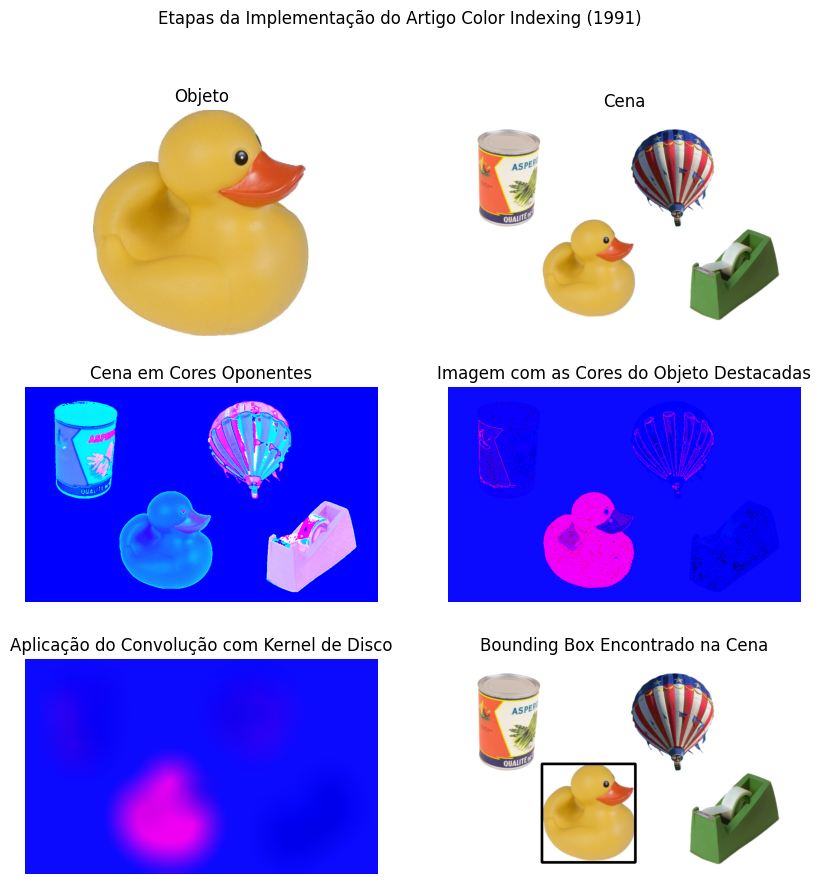

In [167]:
# Indica o índica da imagem que se deseja plotar
index = 4
images_to_plot = to_plot[index]

# Plot dos passos da método
images = list(images_to_plot.values())
titles = list(images_to_plot.keys())
         
plot_images(images, titles, title="Etapas da Implementação do Artigo Color Indexing (1991)", num_rows=3, fig_size=(10 , 10))

* Plot do resultado encontrado

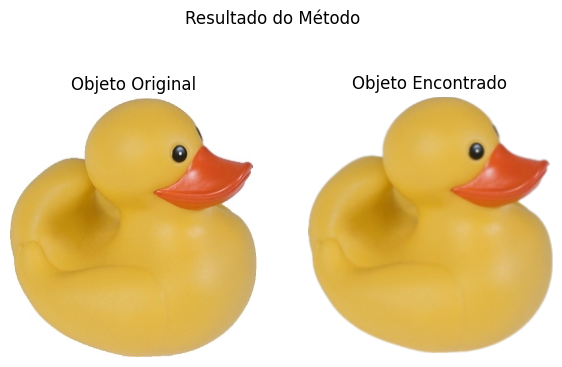

In [168]:
# Indica o índica da imagem que se deseja plotar
index = 4

# Plot da imagem original e da imagem encontrada
cropped_scene = cropped_images[index]
object_image = to_plot[index]["Objeto"]
plot_2_images(object_image, cropped_scene, "Objeto Original", "Objeto Encontrado", "Resultado do Método", fig_size=(7, 5))